In [3]:
import json
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
import csv
from tensorflow.keras import optimizers
import keras
from functools import partial
# from keras.backend import sigmoid
from math import exp
from tensorflow.keras.utils import get_custom_objects
from keras.layers import Activation
from keras.callbacks import ModelCheckpoint
import numpy as np
from sklearn.preprocessing import StandardScaler
import os
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report 
import joblib
import pickle
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score, roc_curve
from itertools import cycle

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

IndexError: list index out of range

In [14]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Set only the first GPU as visible
        tf.config.set_visible_devices(gpus[0], 'GPU')
        # Allow memory growth to allocate memory dynamically on the GPU
        tf.config.experimental.set_memory_growth(gpus[0], True)
        print("GPU configuration successful.")
    except RuntimeError as e:
        print(e)
else:
    print("No GPU detected.")

No GPU detected.


In [13]:
def load_data(data_path):
    """Loads training dataset from json file.
    :param data_path (str): Path to json file containing data
    :return X (ndarray): Inputs
    :return y (ndarray): Targets
    """
    with open(data_path, "r") as fp:
        data = json.load(fp)
   
    X = np.array(data["MFCCs"])
    
    y = np.array(data["labels"])
    y = y[..., np.newaxis]

    #y = y -1
    print("Training sets loaded!")
    
    print(X.shape)
    print(y.shape)
    
    return X, y

In [6]:
def prepare_dataset(data_path, test_size=0.2, validation_size=0.2):
    """Creates train, validation and test sets.
    :param data_path (str): Path to json file containing data
    :param test_size (flaot): Percentage of dataset used for testing
    :param validation_size (float): Percentage of train set used for cross-validation
    :return X_train (ndarray): Inputs for the train set
    :return y_train (ndarray): Targets for the train set
    :return X_validation (ndarray): Inputs for the validation set
    :return y_validation (ndarray): Targets for the validation set
    :return X_test (ndarray): Inputs for the test set
    :return X_test (ndarray): Targets for the test set
    """

    # load dataset
    X, y = load_data(data_path)
    #print(X.shape)
    
    ################################## Scaleing the data #############################
    scaler = StandardScaler()
    num_instances, num_time_steps, num_features = X.shape
    #print(num_instances)
    #print(num_time_steps)
    #print(num_features)
    #X = np.reshape(X, shape=(-1, num_features))
    X = X.reshape(-1, num_features)
    #print(X.shape)
    X = scaler.fit_transform(X)
    
    #####################################
    # Save the scaler to a file
    joblib.dump(scaler, './scaler/scaler.pkl')
    #####################################
    
    #reshapeing
    #X = np.reshape(X, shape=(num_instances, num_time_steps, num_features))
    X = X.reshape(num_instances, num_time_steps, num_features) 
    #print(X.shape)
    ##################################################################################
    
    # create train, validation, test split
    X_train_1, X_test, y_train_1, y_test = train_test_split(X,y, stratify= y, test_size=test_size, random_state=50)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train_1,y_train_1,  stratify= y_train_1, test_size=validation_size, random_state=50)


    print(X_train.shape)
    # add an axis to nd array
    X_train = X_train[..., np.newaxis]
    X_test = X_test[..., np.newaxis]
    X_validation = X_validation[..., np.newaxis]
    

    
    


    return X_train, y_train, X_validation, y_validation, X_test, y_test

In [7]:
# This function keeps the initial learning rate for the first ten epochs
# and decreases it exponentially after that.
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return float(lr * tf.math.exp(-0.1))
        #return lr * tf.math.exp(-0.1)
        #return lr * ops.exp(-0.1)

def train(model, epochs, batch_size, patience, X_train, y_train, X_validation, y_validation,checkpoint_path):
    """Trains model
    :param epochs (int): Num training epochs
    :param batch_size (int): Samples per batch
    :param patience (int): Num epochs to wait before early stop, if there isn't an improvement on accuracy
    :param X_train (ndarray): Inputs for the train set
    :param y_train (ndarray): Targets for the train set
    :param X_validation (ndarray): Inputs for the validation set
    :param y_validation (ndarray): Targets for the validation set
    :return history: Training history
    """
    Learning_Rate_Scheduler = keras.callbacks.LearningRateScheduler(scheduler)
    #earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", min_delta=0.001, patience=patience,mode='max')
    checkpoint_callback = keras.callbacks.ModelCheckpoint(checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

    # train model
    history = model.fit(X_train,
                        y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(X_validation, y_validation),
                        callbacks=[checkpoint_callback,Learning_Rate_Scheduler], verbose=1)  #[earlystop_callback, checkpoint_callback,Learning_Rate_Scheduler]

    return history

In [8]:
def plot_history(history):
    """Plots accuracy/loss for training/validation set as a function of the epochs
    :param history: Training history of model
    :return:
    """

    fig, axs = plt.subplots(2)

    # create accuracy subplot
    axs[0].plot(history.history["accuracy"], label="train_accuracy")
    axs[0].plot(history.history['val_accuracy'], label="val_accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy evaluation")

    # create loss subplot
    axs[1].plot(history.history["loss"], label="train_loss")
    axs[1].plot(history.history['val_loss'], label="val_loss")
    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("Loss")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Loss evaluation")

    plt.show()
    
    # Exclude the first few epochs so the graph is easier to read
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(1, len(loss) + 1)
    
    plt.plot(epochs, loss, 'g.', label='Training loss')
    plt.plot(epochs, val_loss, 'rx', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [25]:
from sklearn.metrics import roc_curve


def compute_eer(y_true, y_scores, pos_label=1):
    fpr, tpr, thresholds = roc_curve(y_true, y_scores, pos_label=pos_label)
    fnr = 1 - tpr
    eer_threshold = thresholds[np.nanargmin(np.absolute(fnr - fpr))]
    eer = fpr[np.nanargmin(np.absolute(fnr - fpr))]
    return eer

def compute_multiclass_eer(y_test, y_pred_scores):
    # Number of classes
    num_classes = y_pred_scores.shape[1]
    
    # Initialize variable to accumulate EER
    total_eer = 0
    
    # Compute EER for each class using one-vs-all approach
    for i in range(num_classes):
        # Create binary labels for class i
        y_test_binary = (y_test == i).astype(int)
        y_pred_binary_scores = y_pred_scores[:, i]
        
        # Compute EER for the current class
        eer = compute_eer(y_test_binary, y_pred_binary_scores, pos_label=1)
        total_eer += eer
    
    # Average EER over all classes
    avg_eer = total_eer / num_classes
    
    return avg_eer


def compute_cavg_multiclass(y_test, y_pred, p_target=0.5, c_miss=1, c_fa=1):
    
    num_classes = 6
    
    # Calculate confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Number of classes
    num_classes = cm.shape[0]
    
    # Initialize variables to accumulate costs
    total_cost = 0
    total_samples = len(y_test)
    
    # Iterate through each class to calculate miss and false alarm costs
    for i in range(num_classes):
        # True Positives, False Positives, False Negatives for class i
        TP = cm[i, i]
        FP = np.sum(cm[:, i]) - TP
        FN = np.sum(cm[i, :]) - TP
        
        # Miss and false alarm probabilities
        p_miss = FN / (FN + TP) if (FN + TP) > 0 else 0
        p_fa = FP / (FP + (total_samples - FN - TP)) if (FP + (total_samples - FN - TP)) > 0 else 0
        
        # Calculate the cost for this class
        cost = p_target * c_miss * p_miss + (1 - p_target) * c_fa * p_fa
        
        # Accumulate the cost
        total_cost += cost
    
    # Average cost over all classes
    cavg = total_cost / num_classes
    
    return cavg

In [15]:
DATA_PATH = "data_new.json"
class_names = ['down', 'up', 'on', 'unknown', 'background_noise', 'off']
EPOCHS = 50
BATCH_SIZE = 128
PATIENCE = 5
LEARNING_RATE = 0.0001
SKIP = 1
CLASS =6 

In [16]:
# generate train, validation and test sets
X_train, y_train, X_validation, y_validation, X_test, y_test = prepare_dataset(DATA_PATH)
#print(y_test)
#print(np.isnan(y_train))

Training sets loaded!
(24, 61, 13)
(24, 1)
(15, 61, 13)


# 2D_CNN

In [28]:
def leaky_relu(z, name =None):
    return tf.maximum(0.01*z,z, name= name)
def sigmoid(x):
    z = 1/(1 + np.exp(-x))
    return z

def swish(x,name =None):     # or   silu  both are same
    return (x.sigmoid(x)*x)
    

get_custom_objects().update({'swish': Activation(swish)})

def build_model(input_shape, learning_rate, loss="sparse_categorical_crossentropy"):
    """Build neural network using keras.
    :param input_shape (tuple): Shape of array representing a sample train. E.g.: (61, 13, 1)
    :param loss (str): Loss function to use
    :param learning_rate (float):
    :return model: TensorFlow model
    """
    
    # build network architecture using convolutional layers
    model = tf.keras.models.Sequential()
    # 1st conv layer

    model.add(tf.keras.layers.Conv2D(64, (3, 3), activation="silu",padding='same', input_shape=input_shape))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPooling2D((3, 3), strides=(2,2), padding='same'))
    tf.keras.layers.Dropout(0.5)

    # 2nd conv layer
    model.add(tf.keras.layers.Conv2D(32, (3, 3), activation="silu",padding='same'))                              
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPooling2D((3, 3), strides=(2,2), padding='same'))
    tf.keras.layers.Dropout(0.5)
    
#     # 3rd conv layer
    
#     model.add(tf.keras.layers.Conv2D(128, (3, 3), activation="silu",padding='same')) 
#     #model.add(tf.keras.layers.Conv2D(128, (3, 3), activation="silu",padding='same'))                               
#     model.add(tf.keras.layers.BatchNormalization())
#     #model.add(tf.keras.layers.MaxPooling2D((3, 3), strides=(2,2), padding='same'))
#     tf.keras.layers.Dropout(0.3)
    

    # flatten output and feed into dense layer
    model.add(tf.keras.layers.Flatten())
#     model.add(tf.keras.layers.Dense(128, activation="silu"))
#     tf.keras.layers.Dropout(0.5)
    model.add(tf.keras.layers.Dense(64, activation="silu"))
    tf.keras.layers.Dropout(0.5)

    # softmax output layer
    model.add(tf.keras.layers.Dense(CLASS, activation='softmax'))


    optimiser = tf.optimizers.Adam(learning_rate=learning_rate, epsilon = 1e-08)   #, decay = 0.0)
    
    #optimiser= keras.optimizers.RMSprop(learning_rate=learning_rate, momentum =0.9, epsilon = 1e-10)
    # compile model
    model.compile(optimizer=optimiser,
                  loss=loss,
                  metrics=["accuracy"])  

    # print model parameters on console
    model.summary()

    return model

(14457, 61, 13, 1)
(14457, 1)


/home/soumen/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 61, 13, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 61, 13, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 31, 7, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 31, 7, 32)      │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 31, 7, 32)      │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 16, 4, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 64)             │       131,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 151,014 (589.90 KB)

 Trainable params: 150,822 (589.15 KB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.3989 - loss: 1.6166
Epoch 1: val_accuracy improved from -inf to 0.34467, saving model to /home/soumen/Soumen/model/KWS/project_1/2D_CNN.keras
113/113 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.3997 - loss: 1.6137 - val_accuracy: 0.3447 - val_loss: 1.6728 - learning_rate: 1.0000e-04
Epoch 2/50
109/113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6547 - loss: 0.8920
Epoch 2: val_accuracy improved from 0.34467 to 0.50346, saving model to /home/soumen/Soumen/model/KWS/project_1/2D_CNN.keras
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6557 - loss: 0.8895 - val_accuracy: 0.5035 - val_loss: 1.3971 - learning_rate: 1.0000e-04
Epoch 3/50
107/113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7495 - loss: 0.6893
Epoch 3: val_accuracy improved from 0.50346 to 0.67773, saving model to /home/soumen/Soumen/model/KWS/project_1/2D_CNN.keras
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7498 - loss: 0.6883 - v

113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9858 - loss: 0.0848 - val_accuracy: 0.8642 - val_loss: 0.3870 - learning_rate: 3.6883e-06
Epoch 44/50
108/113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9883 - loss: 0.0797
Epoch 44: val_accuracy did not improve from 0.86473
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9882 - loss: 0.0798 - val_accuracy: 0.8633 - val_loss: 0.3871 - learning_rate: 3.3373e-06
Epoch 45/50
103/113 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9894 - loss: 0.0772
Epoch 45: val_accuracy did not improve from 0.86473
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9893 - loss: 0.0775 - val_accuracy: 0.8645 - val_loss: 0.3869 - learning_rate: 3.0197e-06
Epoch 46/50
109/113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9881 - loss: 0.0780
Epoch 46: val_accuracy did not improve from 0.86473
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9881 - loss: 0.0781 - val_accuracy: 0.8647 - val_loss: 0.3870 - learning_rate: 2.7324e-06
Epo

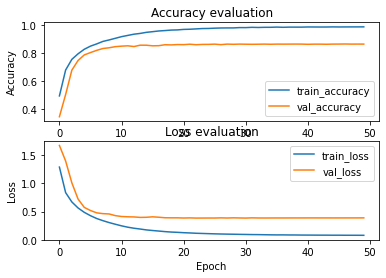

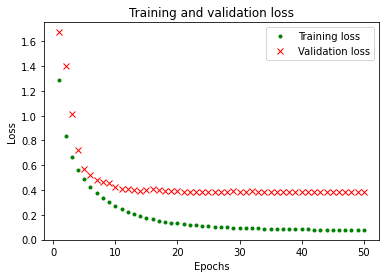

142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8660 - loss: 0.4182

Test loss: 0.4135207235813141, test accuracy: 86.56485080718994
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Confusion Matrix:
[[677  11  16  75   0   4]
 [  6 648  23  22   1  45]
 [  7  28 663  24   0  47]
 [ 80  31  46 555   1  19]
 [  0   0   0   0 740   0]
 [  2  75  30  13   1 628]]

Precision: 0.8655321170893158
Recall: 0.8656485170429393
F1 Score: 0.8653234333849725
EER: 0.7585
Cavg: 0.0802
Macro-average AUC-ROC Score: 0.9810411646055458
Weighted-average AUC-ROC Score: 0.9811100889284009


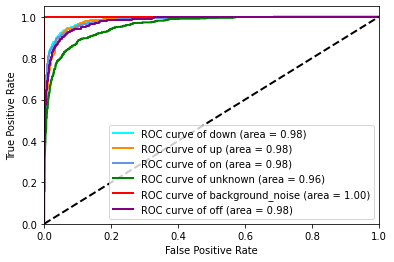

In [35]:
checkpoint_path = "/home/soumen/Soumen/model/KWS/project_1/2D_CNN.keras"
SAVED_MODEL_PATH = "/home/soumen/Soumen/model/KWS/project_1/2D_CNN.h5" 

# create network
input_shape = (X_train.shape[1], X_train.shape[2], 1)
print(X_train.shape)
print(y_train.shape)
model = build_model(input_shape, learning_rate=LEARNING_RATE)

# train network
history = train(model, EPOCHS, BATCH_SIZE, PATIENCE, X_train, y_train, X_validation, y_validation,checkpoint_path)

# plot accuracy/loss for training/validation set as a function of the epochs
plot_history(history)

# evaluate network on test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print("\nTest loss: {}, test accuracy: {}".format(test_loss, 100*test_acc))

# Making predictions on the test set
y_pred_probs = model.predict(X_test)  # Assuming model output probabilities for each class
y_pred = y_pred_probs.argmax(axis=1)  # Extracting the index of the class with the highest probability

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Calculate precision, recall, and F1 score (use 'average' parameter for multi-class problems)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("\nPrecision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

############################

eer = compute_eer(y_test, y_pred)
cavg = compute_cavg_multiclass(y_test, y_pred)

print(f"EER: {eer:.4f}")
print(f"Cavg: {cavg:.4f}")
###########################
# Binarize the output labels for multiclass ROC AUC computation
y_bin = label_binarize(y_test, classes=np.arange(CLASS))

#print(f"y shape: {y.shape}")
#print(f"y_pred_prob shape: {y_pred_prob.shape}")

# Compute AUC-ROC score for each class
auc_scores = []
for i in range(CLASS):
    auc = roc_auc_score(y_bin[:, i], y_pred_probs[:, i])
    auc_scores.append(auc)
    #print(f"AUC-ROC Score for class {class_names[i]}: {auc}")

# Compute macro-average AUC-ROC score
macro_roc_auc_ovr = roc_auc_score(y_bin, y_pred_probs, average="macro", multi_class="ovr")
print(f"Macro-average AUC-ROC Score: {macro_roc_auc_ovr}")

# Compute weighted-average AUC-ROC score
weighted_roc_auc_ovr = roc_auc_score(y_bin, y_pred_probs, average="weighted", multi_class="ovr")
print(f"Weighted-average AUC-ROC Score: {weighted_roc_auc_ovr}")

# Plot ROC curves for each class
fpr = dict()
tpr = dict()
for i in range(CLASS):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_pred_probs[:, i])

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple'])
plt.figure()
for i, color in zip(range(CLASS), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label='ROC curve of {0} (area = {1:0.2f})'.format(class_names[i], auc_scores[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.title('Receiver Operating Characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()
###########################
# Check if the file already exists and delete it
if os.path.exists(SAVED_MODEL_PATH):
    os.remove(SAVED_MODEL_PATH)


    # save model
model.save(SAVED_MODEL_PATH)


# 1D CNN

In [36]:
############################# Run one time for removing the axis #########################
# Remove the added axis
X_train = np.squeeze(X_train, axis=-1)
X_test = np.squeeze(X_test, axis=-1)
X_validation = np.squeeze(X_validation, axis=-1)

###########################################################################################

In [37]:
from keras.models import Sequential
from keras.layers import Conv1D, Flatten, GlobalAveragePooling1D, Dense

def build_1D_CNN_model(input_shape, learning_rate , loss="sparse_categorical_crossentropy"):
    model = Sequential()
    
    # Add 1D-CNN layers
    model.add(Conv1D(filters=500, kernel_size=5, strides=1, activation='relu', input_shape= input_shape))   #(None, 1)
    model.add(Conv1D(filters=500, kernel_size=7, strides=2, activation='relu'))
    model.add(Conv1D(filters=500, kernel_size=1, strides=1, activation='relu'))
    #model.add(Conv1D(filters=3000, kernel_size=1, strides=1, activation='relu'))
    
    model.add(keras.layers.Dropout(0.3))
    
    # Global average pooling
    model.add(GlobalAveragePooling1D())

    # Fully connected layers
    model.add(Dense(1500, activation='relu'))
    model.add(Dense(600, activation='relu'))

    # Softmax layer
    model.add(Dense(CLASS, activation='softmax'))

    
    optimiser = tf.optimizers.Adam(learning_rate=learning_rate, epsilon=1e-08) #, decay=0.0)
    
    model.compile(optimizer=optimiser, loss=loss,metrics=["accuracy"])  
    
    model.summary()

    return model

(14457, 61, 13)
(14457, 1)
(61, 13)


/home/soumen/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_9 (Conv1D)               │ (None, 57, 500)        │        33,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_10 (Conv1D)              │ (None, 26, 500)        │     1,750,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_11 (Conv1D)              │ (None, 26, 500)        │       250,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 26, 500)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_2      │ (None, 500)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1500)           │       751,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 600)            │       900,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 6)              │         3,606 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,689,706 (14.08 MB)

 Trainable params: 3,689,706 (14.08 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5277 - loss: 1.2738
Epoch 1: val_accuracy improved from -inf to 0.70041, saving model to /home/soumen/Soumen/model/KWS/project_1/1D_CNN.keras
113/113 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - accuracy: 0.5284 - loss: 1.2717 - val_accuracy: 0.7004 - val_loss: 0.8029 - learning_rate: 1.0000e-04
Epoch 2/50
111/113 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7306 - loss: 0.7362
Epoch 2: val_accuracy improved from 0.70041 to 0.78838, saving model to /home/soumen/Soumen/model/KWS/project_1/1D_CNN.keras
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7313 - loss: 0.7347 - val_accuracy: 0.7884 - val_loss: 0.5818 - learning_rate: 1.0000e-04
Epoch 3/50
110/113 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8129 - loss: 0.5319
Epoch 3: val_accuracy improved from 0.78838 to 0.84066, saving model to /home/soumen/Soumen/model/KWS/project_1/1D_CNN.keras
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8132 - loss: 0.5310 - v

Epoch 44/50
110/113 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9873 - loss: 0.0447
Epoch 44: val_accuracy did not improve from 0.93942
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9873 - loss: 0.0446 - val_accuracy: 0.9389 - val_loss: 0.1913 - learning_rate: 3.3373e-06
Epoch 45/50
109/113 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9880 - loss: 0.0415
Epoch 45: val_accuracy did not improve from 0.93942
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9880 - loss: 0.0415 - val_accuracy: 0.9386 - val_loss: 0.1913 - learning_rate: 3.0197e-06
Epoch 46/50
106/113 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9893 - loss: 0.0414
Epoch 46: val_accuracy did not improve from 0.93942
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9892 - loss: 0.0415 - val_accuracy: 0.9380 - val_loss: 0.1912 - learning_rate: 2.7324e-06
Epoch 47/50
106/113 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9891 - loss: 0.0392
Epoch 47: val_accuracy did not improve from 0.93942
113/113 ━

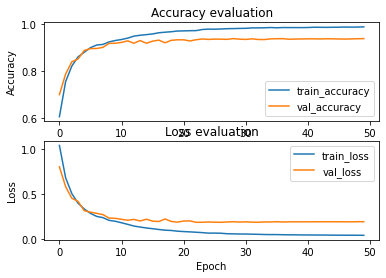

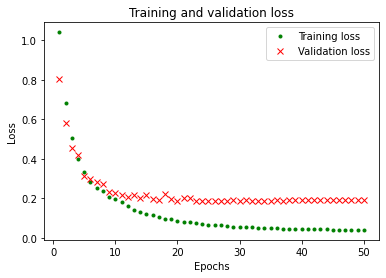

142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Confusion Matrix:
[[736   3   8  32   0   4]
 [  5 693   9  17   0  21]
 [  5  16 710  19   0  19]
 [ 36  20  14 652   0  10]
 [  0   0   0   0 740   0]
 [  2  24  25   3   0 695]]
                  precision    recall  f1-score   support

            down       0.94      0.94      0.94       783
              up       0.92      0.93      0.92       745
              on       0.93      0.92      0.93       769
         unknown       0.90      0.89      0.90       732
background_noise       1.00      1.00      1.00       740
             off       0.93      0.93      0.93       749

        accuracy                           0.94      4518
       macro avg       0.94      0.94      0.94      4518
    weighted avg       0.94      0.94      0.94      4518

142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9332 - loss: 0.2107

Test loss: 0.20591062307357788, test accuracy: 93.5369610786438

Precision: 0.9353419107083337
Recall: 0.9353696325807

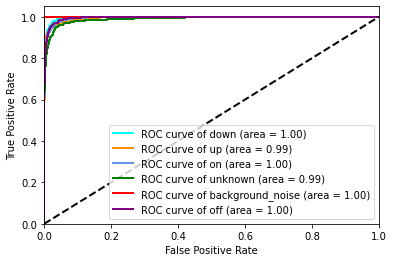

In [38]:
import os
checkpoint_path = "/home/soumen/Soumen/model/KWS/project_1/1D_CNN.keras"
SAVED_MODEL_PATH = "/home/soumen/Soumen/model/KWS/project_1/1D_CNN.h5" 



# Reshape the input data to match the expected shape of the model

input_shape=X_train.shape[1:]
print(X_train.shape)
print(y_train.shape)
print(input_shape)

#print(input_shape.shape)
#print(X_validation_reshaped.shape)

#print(input_shape)
model = build_1D_CNN_model(input_shape, learning_rate=LEARNING_RATE)

# train network
history = train(model, EPOCHS, BATCH_SIZE, PATIENCE, X_train, y_train, X_validation, y_validation,checkpoint_path)
# plot accuracy/loss for training/validation set as a function of the epochs
plot_history(history)



# Making predictions on the test set
y_pred_probs = model.predict(X_test)  # Assuming model output probabilities for each class
y_pred = y_pred_probs.argmax(axis=1)  # Extracting the index of the class with the 

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# show classification report 
print(classification_report(y_test, y_pred, target_names=class_names))

    # evaluate network on test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print("\nTest loss: {}, test accuracy: {}".format(test_loss, 100*test_acc))

# Calculate precision, recall, and F1 score (use 'average' parameter for multi-class problems)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("\nPrecision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

############################


eer = compute_eer(y_test, y_pred)
cavg = compute_cavg_multiclass(y_test, y_pred)

print(f"EER: {eer:.4f}")
print(f"Cavg: {cavg:.4f}")
###########################
###########################
# Binarize the output labels for multiclass ROC AUC computation
y_bin = label_binarize(y_test, classes=np.arange(CLASS))

#print(f"y shape: {y.shape}")
#print(f"y_pred_prob shape: {y_pred_prob.shape}")

# Compute AUC-ROC score for each class
auc_scores = []
for i in range(CLASS):
    auc = roc_auc_score(y_bin[:, i], y_pred_probs[:, i])
    auc_scores.append(auc)
    #print(f"AUC-ROC Score for class {class_names[i]}: {auc}")

# Compute macro-average AUC-ROC score
macro_roc_auc_ovr = roc_auc_score(y_bin, y_pred_probs, average="macro", multi_class="ovr")
print(f"Macro-average AUC-ROC Score: {macro_roc_auc_ovr}")

# Compute weighted-average AUC-ROC score
weighted_roc_auc_ovr = roc_auc_score(y_bin, y_pred_probs, average="weighted", multi_class="ovr")
print(f"Weighted-average AUC-ROC Score: {weighted_roc_auc_ovr}")

# Plot ROC curves for each class
fpr = dict()
tpr = dict()
for i in range(CLASS):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_pred_probs[:, i])

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple'])
plt.figure()
for i, color in zip(range(CLASS), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label='ROC curve of {0} (area = {1:0.2f})'.format(class_names[i], auc_scores[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.title('Receiver Operating Characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()
########################
# Check if the file already exists and delete it
if os.path.exists(SAVED_MODEL_PATH):
    os.remove(SAVED_MODEL_PATH)

# save model
model.save(SAVED_MODEL_PATH)

# TCN

In [39]:
from tensorflow import keras
from tensorflow.keras import layers

def tcn_block(inputs, filters, kernel_size, dilation_rate):
    """A dilated convolutional block with skip connections."""
    conv = layers.Conv1D(filters, kernel_size, dilation_rate=dilation_rate, padding="causal")(inputs)
    conv = layers.BatchNormalization()(conv)
    conv = layers.Activation("relu")(conv)
    skip = layers.Conv1D(filters, 1, padding="causal")(inputs)
    skip = layers.BatchNormalization()(skip)
    output = layers.add([conv, skip])
    return output

def create_tcn_model(input_shape, learning_rate, loss="sparse_categorical_crossentropy"):
    """Creates a TCN model."""
    inputs = keras.Input(shape=input_shape)
    x = tcn_block(inputs, 32, 3, 1)  # Block 1
    x = tcn_block(x, 64, 3, 2)   # Block 2
    x = tcn_block(x, 128, 3, 4)   # Block 3
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(500, activation='relu')(x)
    x = layers.Dense(500, activation='relu')(x)
    x = layers.Dense(300, activation='relu')(x)
    outputs = layers.Dense(CLASS, activation="softmax")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    
    optimiser = tf.optimizers.Adam(learning_rate=learning_rate, epsilon=1e-08)   #, decay=0.0)  
    model.compile(optimizer=optimiser, loss=loss,metrics=["accuracy"]) 
    
    model.summary()
    
    return model

(14457, 61, 13)
(14457, 1)
(61, 13)


Model: "functional_73"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 61, 13)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_12 (Conv1D)  │ (None, 61, 32)    │      1,280 │ input_layer_9[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 61, 32)    │        128 │ conv1d_12[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_13 (Conv1D)  │ (None, 61, 32)    │        448 │ input_layer_9[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_5        │ (None, 61, 32)    │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 61, 32)    │        128 │ conv1d_13[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 61, 32)    │          0 │ activation_5[0][… │
│                     │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_14 (Conv1D)  │ (None, 61, 64)    │      6,208 │ add_3[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 61, 64)    │        256 │ conv1d_14[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_15 (Conv1D)  │ (None, 61, 64)    │      2,112 │ add_3[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_6        │ (None, 61, 64)    │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 61, 64)    │        256 │ conv1d_15[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 61, 64)    │          0 │ activation_6[0][… │
│                     │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_16 (Conv1D)  │ (None, 61, 128)   │     24,704 │ add_4[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 61, 128)   │        512 │ conv1d_16[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_17 (Conv1D)  │ (None, 61, 128)   │      8,320 │ add_4[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_7        │ (None, 61, 128)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 61, 128)   │        512 │ conv1d_17[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_5 (Add)         │ (None, 61, 128)   │          0 │ activation_7[0][

 Total params: 511,970 (1.95 MB)

 Trainable params: 511,074 (1.95 MB)

 Non-trainable params: 896 (3.50 KB)

Epoch 1/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.4400 - loss: 1.3749
Epoch 1: val_accuracy improved from -inf to 0.59779, saving model to /home/soumen/Soumen/model/KWS/project_1/TCN.keras
113/113 ━━━━━━━━━━━━━━━━━━━━ 18s 84ms/step - accuracy: 0.4409 - loss: 1.3731 - val_accuracy: 0.5978 - val_loss: 1.0204 - learning_rate: 1.0000e-04
Epoch 2/50
112/113 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6394 - loss: 0.9210
Epoch 2: val_accuracy improved from 0.59779 to 0.66501, saving model to /home/soumen/Soumen/model/KWS/project_1/TCN.keras
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6396 - loss: 0.9205 - val_accuracy: 0.6650 - val_loss: 0.8779 - learning_rate: 1.0000e-04
Epoch 3/50
105/113 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7050 - loss: 0.7860
Epoch 3: val_accuracy improved from 0.66501 to 0.72752, saving model to /home/soumen/Soumen/model/KWS/project_1/TCN.keras
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7057 - loss: 0.7845 - val_accur

Epoch 43/50
104/113 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9437 - loss: 0.1747
Epoch 43: val_accuracy did not improve from 0.89350
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9436 - loss: 0.1749 - val_accuracy: 0.8918 - val_loss: 0.3129 - learning_rate: 3.6883e-06
Epoch 44/50
107/113 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9407 - loss: 0.1789
Epoch 44: val_accuracy did not improve from 0.89350
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9407 - loss: 0.1789 - val_accuracy: 0.8929 - val_loss: 0.3118 - learning_rate: 3.3373e-06
Epoch 45/50
107/113 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9413 - loss: 0.1762
Epoch 45: val_accuracy did not improve from 0.89350
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9412 - loss: 0.1763 - val_accuracy: 0.8932 - val_loss: 0.3116 - learning_rate: 3.0197e-06
Epoch 46/50
112/113 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9429 - loss: 0.1726
Epoch 46: val_accuracy did not improve from 0.89350
113/113 ━

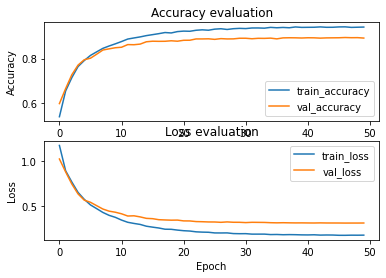

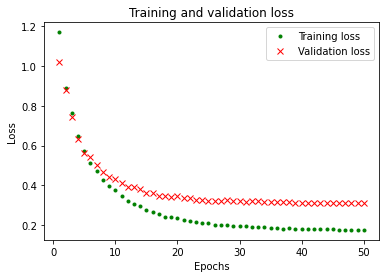

142/142 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.8908 - loss: 0.3260

Test loss: 0.3237115144729614, test accuracy: 88.82248997688293
142/142 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
Confusion Matrix:
[[697  13  14  58   0   1]
 [ 10 659  15  29   1  31]
 [ 10  15 687  27   0  30]
 [ 65  31  36 580   0  20]
 [  0   0   0   0 740   0]
 [  4  34  39  21   1 650]]

Precision: 0.8880011412736103
Recall: 0.8882248782647189
F1 Score: 0.8880420470771185
EER: 0.7697
Cavg: 0.0669
Macro-average AUC-ROC Score: 0.9866838297487077
Weighted-average AUC-ROC Score: 0.986753864972019


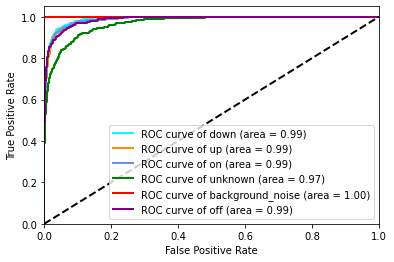

In [40]:
import os
checkpoint_path = "/home/soumen/Soumen/model/KWS/project_1/TCN.keras"
SAVED_MODEL_PATH = "/home/soumen/Soumen/model/KWS/project_1/TCN.h5" 


# Reshape the input data to match the expected shape of the model

input_shape=X_train.shape[1:]
print(X_train.shape)
print(y_train.shape)
print(input_shape)

#print(input_shape.shape)
#print(X_validation_reshaped.shape)

#print(input_shape)

model = create_tcn_model(input_shape, learning_rate=LEARNING_RATE)

# train network
history = train(model, EPOCHS, BATCH_SIZE, PATIENCE, X_train, y_train, X_validation, y_validation,checkpoint_path)
# plot accuracy/loss for training/validation set as a function of the epochs
plot_history(history)

# evaluate network on test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print("\nTest loss: {}, test accuracy: {}".format(test_loss, 100*test_acc))

# Making predictions on the test set
y_pred_probs = model.predict(X_test)  # Assuming model output probabilities for each class
y_pred = y_pred_probs.argmax(axis=1)  # Extracting the index of the class with the 


# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Calculate precision, recall, and F1 score (use 'average' parameter for multi-class problems)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("\nPrecision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

############################
eer = compute_eer(y_test, y_pred)
cavg = compute_cavg_multiclass(y_test, y_pred)

print(f"EER: {eer:.4f}")
print(f"Cavg: {cavg:.4f}")
###########################
###########################
# Binarize the output labels for multiclass ROC AUC computation
y_bin = label_binarize(y_test, classes=np.arange(CLASS))

#print(f"y shape: {y.shape}")
#print(f"y_pred_prob shape: {y_pred_prob.shape}")

# Compute AUC-ROC score for each class
auc_scores = []
for i in range(CLASS):
    auc = roc_auc_score(y_bin[:, i], y_pred_probs[:, i])
    auc_scores.append(auc)
    #print(f"AUC-ROC Score for class {class_names[i]}: {auc}")

# Compute macro-average AUC-ROC score
macro_roc_auc_ovr = roc_auc_score(y_bin, y_pred_probs, average="macro", multi_class="ovr")
print(f"Macro-average AUC-ROC Score: {macro_roc_auc_ovr}")

# Compute weighted-average AUC-ROC score
weighted_roc_auc_ovr = roc_auc_score(y_bin, y_pred_probs, average="weighted", multi_class="ovr")
print(f"Weighted-average AUC-ROC Score: {weighted_roc_auc_ovr}")

# Plot ROC curves for each class
fpr = dict()
tpr = dict()
for i in range(CLASS):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_pred_probs[:, i])

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple'])
plt.figure()
for i, color in zip(range(CLASS), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label='ROC curve of {0} (area = {1:0.2f})'.format(class_names[i], auc_scores[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.title('Receiver Operating Characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()
###########################
# Check if the file already exists and delete it
if os.path.exists(SAVED_MODEL_PATH):
    os.remove(SAVED_MODEL_PATH)

# save model
model.save(SAVED_MODEL_PATH)